In [5]:
# IMPORTACIONES

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models

# Imagen
#import cv2

# Utilidades
from sklearn.metrics import classification_report, confusion_matrix


### 🔹Carga del dataset
Se recorre el directorio que contiene las imágenes del **COVID-19 Radiography Dataset** y se crea un `DataFrame` con las rutas de las imágenes y sus etiquetas (COVID, neumonía, sano, opacidad pulmonar).  
Además, se codifican las etiquetas con `LabelEncoder` para transformarlas a valores numéricos que puedan ser usados por PyTorch.

In [24]:
DATASET_PATH = "COVID-19_Radiography_Dataset/"

categories = os.listdir(DATASET_PATH)
print("Categorías encontradas:", categories)

# Creamos un DataFrame con rutas y etiquetas
data = []
for category in categories:
    folder = os.path.join(DATASET_PATH, category)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        data.append((img_path, category))

df = pd.DataFrame(data, columns=["image_path", "label"])
print("Total de imágenes:", len(df))

#ETIQUETADO
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["label"])
print("Clases codificadas:", label_encoder.classes_)


Categorías encontradas: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
Total de imágenes: 21165
Clases codificadas: ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']


### 🔹División del conjunto de datos
El conjunto completo se divide en tres subconjuntos:
- **Entrenamiento (train):** para ajustar los pesos del modelo.  
- **Validación (val):** para ajustar hiperparámetros y evitar sobreajuste.  
- **Prueba (test):** para evaluar el desempeño final.  

---

In [25]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label_encoded"], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["label_encoded"], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 16932, Val: 2116, Test: 2117


### 🔹Transformaciones y normalización
Se aplican transformaciones con `torchvision.transforms` para preparar las imágenes:
- **Redimensionado a 100×100 píxeles:** reduce el consumo de RAM y GPU.  
- **Recortes y aumentos de datos:** rotaciones, flips y recortes aleatorios para mejorar la generalización.  
- **Conversión a escala de grises:** simplifica las imágenes sin perder información útil.  
- **Normalización:** centra los valores de los píxeles alrededor de 0 para un entrenamiento más estable.

> Estas transformaciones permiten trabajar con un dataset grande sin perder representatividad ni sobrecargar el sistema.

In [26]:
# Transformaciones mejoradas (100×100 + recorte + normalización)

from torchvision import transforms

# Transformaciones para entrenamiento (con aumentos)
train_transforms = transforms.Compose([
    transforms.Resize((120, 120)),              # primero redimensionamos
    transforms.RandomResizedCrop(100),          # recorte aleatorio a 100x100
    transforms.RandomHorizontalFlip(p=0.5),     # reflejo horizontal
    transforms.RandomRotation(10),              # ligera rotación
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])          # normalización
])

# Transformaciones para validación y prueba (sin aleatoriedad)
test_transforms = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.CenterCrop(100),                 # recorte centrado
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


### 🔹Dataset personalizado
Se crea una clase `ChestXrayDataset` que hereda de `torch.utils.data.Dataset`.  
Esta clase:
- Carga las imágenes **bajo demanda** (solo cuando son necesarias).  
- Aplica automáticamente las transformaciones definidas.  
- Devuelve los pares `(imagen, etiqueta)` para PyTorch.

> Esto evita cargar todas las imágenes en memoria al mismo tiempo, optimizando el uso de recursos.

In [27]:
##Clase para dataset personalizado
from torch.utils.data import Dataset
from PIL import Image

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]["image_path"]
        label = self.data.iloc[idx]["label_encoded"]

        # Abrir imagen y convertir a escala de grises
        image = Image.open(img_path).convert("L")

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label


### 🔹DataLoaders
Se generan los `DataLoader` para entrenamiento, validación y prueba, con tamaño de lote (`batch_size=32`) y lectura en paralelo (`num_workers=2`).

> Permiten leer las imágenes por lotes durante el entrenamiento, lo que mejora la eficiencia y facilita el uso de GPU.

In [28]:
#DataLoaders (para cargar por lotes)

from torch.utils.data import DataLoader

train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


### 🔹Visualización de muestras
Finalmente, se muestran algunas imágenes preprocesadas junto con su etiqueta para comprobar:
- Que las rutas sean correctas.  
- Que las transformaciones se apliquen bien.  
- Que las clases correspondan correctamente.

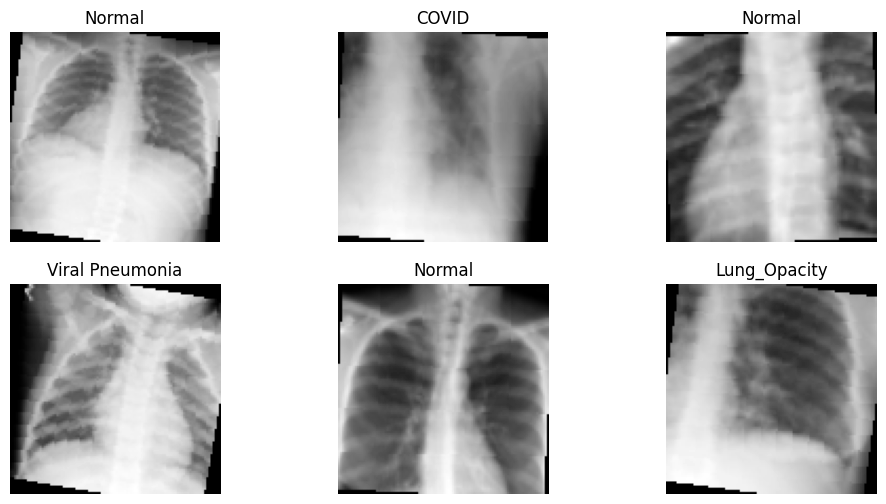

In [29]:
#Visualizacion

import matplotlib.pyplot as plt

def show_samples(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(2, n//2, i+1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(label_encoder.inverse_transform([label])[0])
        plt.axis("off")
    plt.show()

show_samples(train_dataset)
